

# **TASK 1 - AG NEWS**
---

# **IMPORT DEPENDENCIES AND CHECKING**

In [8]:
!pip install transformers datasets evaluate accelerate scikit-learn matplotlib seaborn

In [9]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding # Kita pakai collator bawaan saja
)
from sklearn.metrics import f1_score, accuracy_score
# Hapus BCEWithLogitsLoss, Sigmoid, roc_auc_score (Gak kepakai di AG News)

# ------------------------------------------------------------------
# BAGIAN 1: SETUP & CONFIG
# ------------------------------------------------------------------
# Cek GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# Konfigurasi
MODEL_CKPT = "bert-base-uncased"
BATCH_SIZE = 8
EPOCHS = 3
LEARNING_RATE = 2e-5
MAX_LENGTH = 128
SAMPLE_SIZE = 3000

Device: cuda


# **LOAD DATASET**


In [10]:
# ------------------------------------------------------------------
# BAGIAN 2: LOAD DATASET & LABEL MAPPING (AG NEWS VERSION)
# ------------------------------------------------------------------
print("\n--- Loading Dataset AG News ---")
# 1. Ganti nama dataset jadi "ag_news"
dataset = load_dataset("ag_news")

# 2. Ambil daftar nama label
# Perbedaan: Di AG News nama kolomnya "label" (tunggal), bukan "labels"
# Dan strukturnya langsung .names, tidak perlu .feature.names
labels_list = dataset["train"].features["label"].names
NUM_LABELS = len(labels_list)

# 3. Buat mapping ID <-> Label (Logika sama)
id2label = {idx: label for idx, label in enumerate(labels_list)}
label2id = {label: idx for idx, label in enumerate(labels_list)}

print(f"Total Labels: {NUM_LABELS}")
print(f"Labels: {labels_list}")

# 4. Sampling data
# Perbedaan: AG News bawaannya cuma punya split 'train' dan 'test'.
# Jadi eval_dataset kita ambil dari 'test' saja.
# Pastikan variabel SAMPLE_SIZE sudah didefinisikan di Bagian 1 (misal: 3000)
train_dataset = dataset["train"].shuffle(seed=42).select(range(SAMPLE_SIZE))
eval_dataset = dataset["test"].shuffle(seed=42).select(range(SAMPLE_SIZE // 5))


--- Loading Dataset AG News ---
Total Labels: 4
Labels: ['World', 'Sports', 'Business', 'Sci/Tech']


# **TOKENISASI**

In [11]:
# ------------------------------------------------------------------
# BAGIAN 3: PREPROCESSING (AG NEWS VERSION - SINGLE LABEL)
# ------------------------------------------------------------------
print("\n--- Tokenizing ---")
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

def preprocess_function(examples):
    # Cukup tokenisasi teks saja.
    # Label tidak perlu diotak-atik karena sudah Integer (0, 1, 2, 3)
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=MAX_LENGTH)

# Terapkan ke dataset
encoded_train = train_dataset.map(preprocess_function, batched=True)
encoded_eval = eval_dataset.map(preprocess_function, batched=True)

# --- PERUBAHAN PENTING ---
# 1. Rename kolom 'label' (bawaan AG News) menjadi 'labels' (standar Hugging Face Trainer)
encoded_train = encoded_train.rename_column("label", "labels")
encoded_eval = encoded_eval.rename_column("label", "labels")

# 2. Hapus kolom 'text' mentah agar tidak error saat masuk model
encoded_train = encoded_train.remove_columns(["text"])
encoded_eval = encoded_eval.remove_columns(["text"])

# 3. Set format ke PyTorch Tensor
encoded_train.set_format("torch")
encoded_eval.set_format("torch")

# Verifikasi
print("Contoh data setelah preprocessing:")
print(encoded_train[0])
# Pastikan 'labels' isinya angka biasa (misal: 2), BUKAN list panjang [0.0, 1.0...]


--- Tokenizing ---


Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Contoh data setelah preprocessing:
{'labels': tensor(0), 'input_ids': tensor([  101,  7269, 11498,  2135,  6924,  2011,  9326,  4559, 10134,  2031,
         2716,  2116,  4865,  1998,  3655,  1999,  7269,  2000,  1037,  9190,
         1010,  1996,  2154,  2044,  2324,  2111,  2351,  1999, 18217,  2012,
         1037,  2576,  8320,  1012,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,  

In [12]:
# ------------------------------------------------------------------
# BAGIAN 4: METRICS (AG NEWS VERSION - SINGLE LABEL)
# ------------------------------------------------------------------
def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # PERBEDAAN UTAMA:
    # Karena Single-Label, kita cari nilai tertinggi (Argmax) di antara 4 kelas.
    # Contoh: [0.1, 0.8, 0.05, 0.05] -> Index 1 (Sports) menang.
    predictions = np.argmax(predictions, axis=1)

    # Hitung Akurasi (Wajib untuk klasifikasi berita)
    acc = accuracy_score(labels, predictions)

    # Hitung F1 Score (Weighted rata-rata)
    f1 = f1_score(labels, predictions, average="weighted")

    return {
        "accuracy": acc,
        "f1": f1
    }

# **LOAD PRE-TRAINED MODEL & TRAIN CONFIG**

In [13]:
# ------------------------------------------------------------------
# BAGIAN 5: LOAD MODEL & TRAINING CONFIG (AG NEWS FIXED)
# ------------------------------------------------------------------
print("\n--- Loading Model ---")

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_CKPT,
    num_labels=NUM_LABELS,
    # PERBAIKAN 1: Ganti jadi single_label atau hapus baris ini (biar auto-detect)
    problem_type="single_label_classification",
    id2label=id2label,
    label2id=label2id
)
model.to(device)

training_args = TrainingArguments(
    output_dir="./finetuning-bert-text-classification", # Sesuai nama repo tugas
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy", # Ganti jadi accuracy biar lebih umum
    logging_steps=50,
)

# PERBAIKAN 2: Pakai Collator bawaan (Default)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train,
    eval_dataset=encoded_eval,
    tokenizer=tokenizer,
    data_collator=data_collator, # Jangan pakai CustomDataCollator lagi!
    compute_metrics=compute_metrics,
)

print("Model AG News siap dilatih!")


--- Loading Model ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model AG News siap dilatih!


/tmp/ipython-input-2123304103.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


# **TRAINING**


--- Starting Training ---


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.147000,0.446635,0.903333,0.904051
2,0.113100,0.445577,0.910000,0.910444
3,0.032800,0.501086,0.905000,0.905274



--- Saving Model ---
Model berhasil disimpan di: ./finetuning-bert-text-classification/final_model

--- Visualizing Training History ---


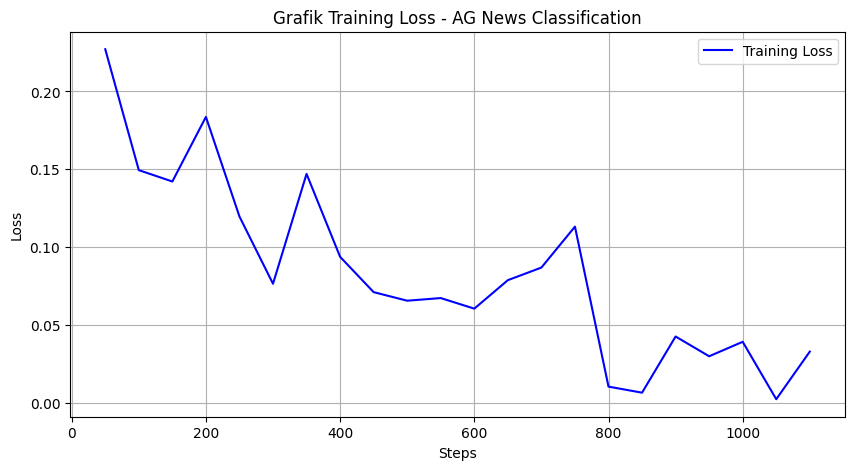


--- Inference (Testing Model Manual) ---
Input Berita: 'Apple just announced the new iPhone with a revolutionary AI chip that changes everything.'

Hasil Prediksi:
Kategori: Sci/Tech
Confidence: 99.87%


In [15]:
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# BAGIAN 6: TRAINING PROCESS
# ------------------------------------------------------------------
print("\n--- Starting Training ---")
train_result = trainer.train()

# Simpan Model Akhir (Sesuaikan dengan nama Repository Tugas)
print("\n--- Saving Model ---")
save_path = "./finetuning-bert-text-classification/final_model"
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)
print(f"Model berhasil disimpan di: {save_path}")

# ------------------------------------------------------------------
# BAGIAN 7: VISUALISASI PROSES TRAINING (LOSS)
# ------------------------------------------------------------------
print("\n--- Visualizing Training History ---")
history = trainer.state.log_history

steps = []
losses = []
for entry in history:
    if "loss" in entry:
        steps.append(entry["step"])
        losses.append(entry["loss"])

plt.figure(figsize=(10, 5))
plt.plot(steps, losses, label="Training Loss", color="blue")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Grafik Training Loss - AG News Classification")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------------------------
# BAGIAN 8: DEFINISI FUNGSI INFERENCE & PENGUJIAN
# ------------------------------------------------------------------
print("\n--- Inference (Testing Model Manual) ---")

# --- INI BAGIAN YANG TADI HILANG ---
def predict_news_category(text, model_path):
    # 1. Load Model & Tokenizer yang sudah dilatih
    # Kita load dari path penyimpanan tadi
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    # 2. Persiapan Input
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)

    # 3. Prediksi
    with torch.no_grad():
        outputs = model(**inputs)

    # 4. Ambil Logits & Hitung Probabilitas (Softmax untuk Single Label)
    logits = outputs.logits
    probs = torch.nn.functional.softmax(logits, dim=-1)

    # 5. Cari skor tertinggi (Argmax)
    pred_idx = torch.argmax(probs, dim=-1).item()

    # Pastikan id2label tersedia (dari bagian sebelumnya)
    pred_label = id2label[pred_idx]
    confidence = probs[0][pred_idx].item()

    return pred_label, confidence

# --- CONTOH PENGGUNAAN ---
text_sample = "Apple just announced the new iPhone with a revolutionary AI chip that changes everything."
print(f"Input Berita: '{text_sample}'")

# Panggil fungsi yang SUDAH didefinisikan di atas
predicted_label, conf = predict_news_category(text_sample, save_path)

print("\nHasil Prediksi:")
print(f"Kategori: {predicted_label}")
print(f"Confidence: {conf:.2%}")

# **VISUALISASI**


--- Inference (Testing Model Manual) ---
Input Berita: 'Apple just announced the new iPhone with a revolutionary AI chip.'

Hasil Prediksi (Confidence):
- Sci/Tech: 99.89%
- Business: 0.05%
- World: 0.03%
- Sports: 0.02%


/tmp/ipython-input-985641419.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_probs, y=top_labels, palette="viridis")


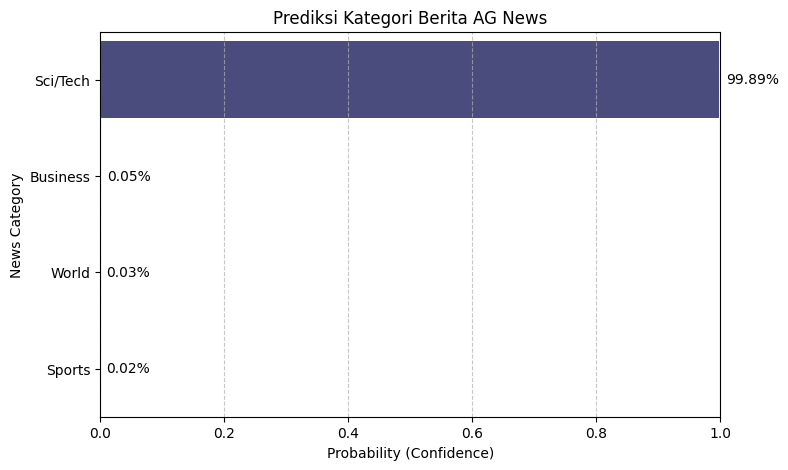

In [16]:
# ------------------------------------------------------------------
# BAGIAN 8: INFERENCE & VISUALISASI HASIL (AG NEWS VERSION)
# ------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Inference (Testing Model Manual) ---")

def predict_news_with_probs(text, model_path):
    # 1. Load Model & Tokenizer
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    # 2. Persiapan Input
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)

    # 3. Prediksi
    with torch.no_grad():
        outputs = model(**inputs)

    # 4. Ambil Logits & Hitung Probabilitas (Softmax)
    logits = outputs.logits
    probs = torch.nn.functional.softmax(logits, dim=-1)

    # Kembalikan probabilitas sebagai array numpy
    return probs.cpu().numpy()[0]

# --- PARAMETER UTAMA ---
text_sample = "Apple just announced the new iPhone with a revolutionary AI chip."
print(f"Input Berita: '{text_sample}'")

# Path folder tugas
save_path = "./finetuning-bert-text-classification/final_model"

# Jalankan Prediksi
probabilities = predict_news_with_probs(text_sample, save_path)

# --- VISUALISASI GRAFIK ---
# Urutkan dari confidence tertinggi ke terendah
# AG News cuma punya 4 label, jadi kita ambil semua
top_indices = probabilities.argsort()[::-1]
top_probs = probabilities[top_indices]
top_labels = [id2label[idx] for idx in top_indices]

# Print Text Hasil
print("\nHasil Prediksi (Confidence):")
for label, prob in zip(top_labels, top_probs):
    print(f"- {label}: {prob:.2%}")

# Plot Grafik Batang
plt.figure(figsize=(8, 5))
sns.barplot(x=top_probs, y=top_labels, palette="viridis")

plt.xlabel("Probability (Confidence)")
plt.ylabel("News Category")
plt.title("Prediksi Kategori Berita AG News")
plt.xlim(0, 1) # Batas 0% sampai 100%
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Tambahkan label angka di ujung batang
for i, v in enumerate(top_probs):
    plt.text(v + 0.01, i, f"{v:.2%}", va='center', fontsize=10)

plt.show()